In [1]:
!pip install MRzeroCore &> /dev/null
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install pytorch-minimize &> /dev/null
!pip install jupyterplot &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [3]:
# @title On Google Colab, you need to restart the runtime after executing this cell
!pip install numpy==1.24

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchkbnufft 1.5.2 requires numpy>=2.0.0, but you have numpy 1.24.0 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.0 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.0 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.0 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.24.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.0 which is 

(IR_FLASH_NN)=
# Pixel-wise NN T1 Mapping

Timing check passed successfully


C:\Users\perez\AppData\Local\Temp\ipykernel_173576\4147478354.py:44: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
C:\Users\perez\AppData\Local\Temp\ipykernel_173576\4147478354.py:50: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf_inv = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)


TypeError: unsupported operand type(s) for +: 'float' and 'list'

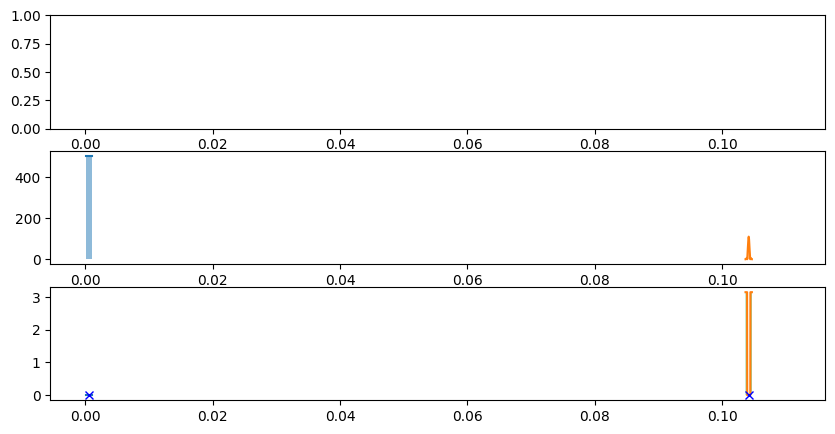

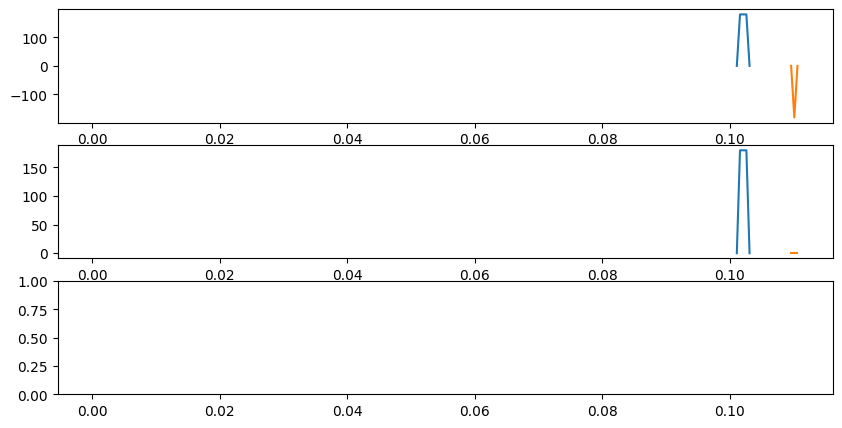

In [3]:
#@title generate 5 IR FLASH images with increasing TI
# %% S0. SETUP env
import MRzeroCore as mr0
import pypulseq as pp
import numpy as np
import torch
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'FLASH_2D_Fit'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(max_grad=28,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s',
                 rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)

TI = [0.1,0.5,1.0,5.0]
n_TI = len(TI)
# Define FOV and resolution
fov = 200e-3
slice_thickness = 8e-3
Nread = 32    # frequency encoding steps/samples
Nphase = 32   # phase encoding steps/samples

##linear reordering
phenc = np.arange(-Nphase // 2, Nphase // 2, 1) / fov
# permvec = np.arange(0, Nphase, 1)
## centric reordering
permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
## random reordering
#perm =np.arange(0, Nphase, 1);  permvec = np.random.permutation(perm)

# %% S2. DEFINE the sequence
def create_inv_rec(TI):
  seq = pp.Sequence()



  # Define rf events
  rf1, _, _ = pp.make_sinc_pulse(
      flip_angle=10 * np.pi / 180, duration=1e-3,
      slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
      system=system, return_gz=True
  )

  rf_inv = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)


  # rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

  # Define other gradients and ADC events
  gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=4e-3, system=system)
  adc = pp.make_adc(num_samples=Nread, duration=4e-3, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
  gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
  gx_spoil = pp.make_trapezoid(channel='x', area=1.5 * gx.area, duration=2e-3, system=system)
  gy_spoil = pp.make_trapezoid(channel='y', area=1.5 * gx.area, duration=2e-3, system=system)

  rf_phase = 0
  rf_inc = 0
  rf_spoiling_inc = 117

  # ======
  # CONSTRUCT SEQUENCE
  # ======

  phenc_centr = phenc[permvec]
  for t in TI:
    seq.add_block(rf_inv)
    seq.add_block(pp.make_delay(t))
    seq.add_block(gx_spoil, gy_spoil)
    for ii in range(0, Nphase):  # e.g. -64:63

        rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase

        adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
        rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
        # increment additional pahse
        rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

        seq.add_block(rf1)
        seq.add_block(pp.make_delay(0.005))
        gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=1e-3, system=system)
        seq.add_block(gx_pre, gp)
        seq.add_block(adc, gx)
        gp = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=1e-3, system=system)
        seq.add_block(gx_spoil, gp)
    seq.add_block(pp.make_delay(10))
  return seq

seq = create_inv_rec(TI)

# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# PLOT sequence
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')


# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [Nread, Nread]
# (i) load a phantom object from file
phantom = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
phantom = phantom.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
phantom.T2dash[:] = 30e-3
phantom.D *= 0
phantom.B0 *= 1    # alter the B0 inhomogeneity
# Store PD and B0 for comparison
PD = phantom.PD
B0 = phantom.B0
T1 = phantom.T1
phantom.plot()
# Convert Phantom into simulation data
obj_p = phantom.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy())

idx = len(TI)-1

fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
kspace = torch.reshape((signal), (len(TI),Nphase, Nread)).clone().permute(0,2,1)
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')

ipermvec = np.argsort(permvec)

kspace=kspace[:,:,ipermvec]
# this adds ticks at the correct position szread
major_ticks = np.arange(0, len(TI)*Nphase * Nread, Nread)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.grid()

# fftshift
spectrum = torch.fft.fftshift(kspace,dim=(1,2))
# FFT
space = torch.fft.fft2(spectrum)
# fftshift
space = torch.fft.ifftshift(space,dim=(1,2))

plt.subplot(345)
plt.title('k-space')
plt.imshow(np.abs(kspace[idx].numpy()))
plt.subplot(349)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace[idx].numpy())))

plt.subplot(346)
plt.title('FFT-magnitude')
plt.imshow(np.abs(space[idx].numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
plt.imshow(np.angle(space[idx].numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom PD')
plt.imshow(PD)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
plt.imshow(B0)

# Pixel-wise NN T1 Mapping

We use a pixel-wise feed-forward model to estimate T1 values.

#1.Define Target

We now copy the true T1 map as T1_target. We also mask the phantom to only non-zero voxels.

In [2]:
T1_target = phantom.T1 # Create Target T1 Map
obj_opt = phantom.build()


meas_mask = torch.zeros_like(phantom.PD)
meas_mask[phantom.PD > 0] = 1
meas_mask = meas_mask[...,0]




#2. Plot functions
Here we define some plotting functions to later plot and update the training status

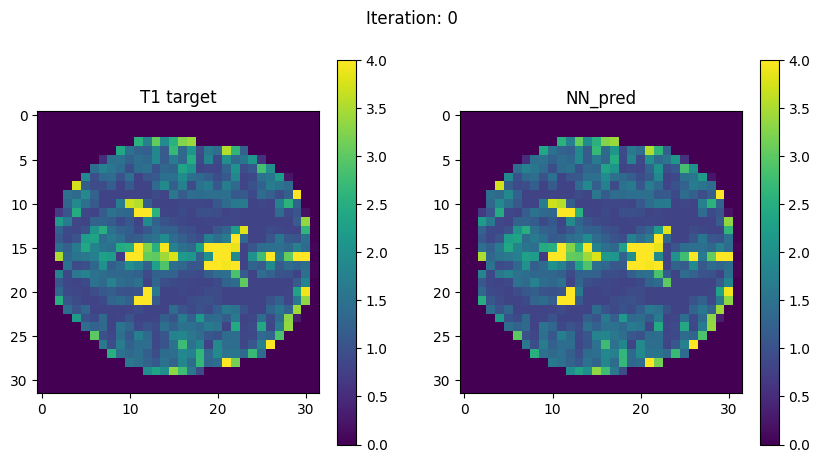

<IPython.core.display.Javascript object>

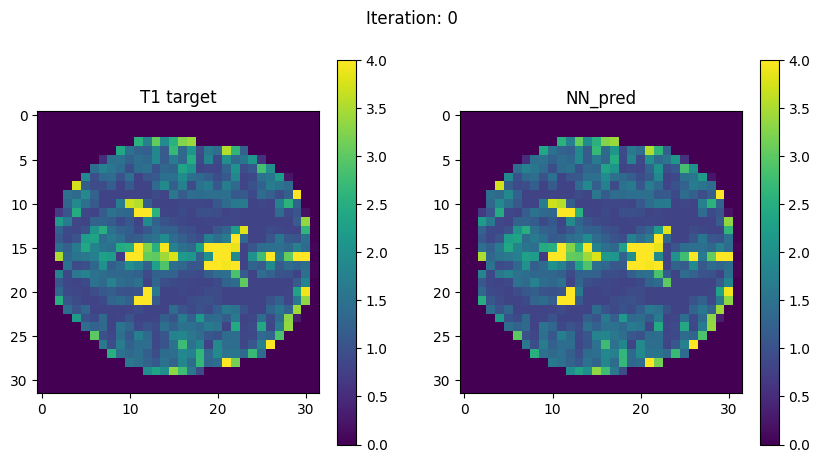

In [3]:
# Create interactive plotting for loss curve and T1 maps

from jupyterplot import ProgressPlot

%matplotlib inline
fig = plt.figure()
fig.suptitle("Iteration: 0")
axes1 = fig.add_subplot(121)
axes2 = fig.add_subplot(122)

hfig = display(fig, display_id=True)

def draw():
  im1 = axes1.imshow(T1_target,clim=(0,4))
  c1 = plt.colorbar(im1)
  im1.set_clim(0,4)
  axes1.set_title('T1 target')
  im2 = axes2.imshow(T1,clim=(0,4))
  c2 = plt.colorbar(im2)
  im2.set_clim(0,4)
  axes2.set_title('NN_pred')
  fig.canvas.draw()
  hfig.update(fig)

def update(T1,iteration):
  fig.suptitle("Iteration: " + str(iteration))
  axes1.cla()
  im1 = axes1.imshow(T1_target,clim=(0,4))
  axes1.set_title('T1 target')
  axes2.cla()
  im2 = axes2.imshow(T1,clim=(0,4))
  axes2.set_title('NN_pred')
  fig.canvas.draw()
  hfig.update(fig)

draw()

loss_history = []

progress_plot = ProgressPlot(x_label = "Iteration", line_names = ["Loss"], width = 800, height = 500)


#3. Define NN for T1 Mapping

We use a pixel-wise feed-forward model to estimate T1 values.

In [4]:
# define NN architecture
import torch.nn as nn
import torch.nn.functional as fnn
class VoxelwiseNet(nn.Module):
    # nmb_conv_neurons_list (list) - number of elements in the list - number of layers, each element of the list - number of conv neurons
    # kernel_size -- convolution kernel size

    def __init__(self,sz,nmb_hidden_neurons,use_gpu=True,gpu_device=0):
        super(VoxelwiseNet, self).__init__()

        self.sz = sz
        self.layer_spec = nmb_hidden_neurons
        self.dense_layers = []

        paramlist = []                                # paramlist for optimizer

        for l_idx in range(len(self.layer_spec)-1):
            # set convolution layers
            dense_layer = nn.Linear(self.layer_spec[l_idx], self.layer_spec[l_idx+1], bias=True)
            self.dense_layers.append(dense_layer)

            if use_gpu:
                dense_layer = dense_layer.cuda(gpu_device)

            for par in dense_layer.parameters():
                paramlist.append(par)

        self.paramlist = nn.ParameterList(paramlist)

    # define forward pass graph
    def forward(self, x):
        for l_idx in range(len(self.layer_spec)-1):
            x = self.dense_layers[l_idx](x)

            if l_idx < len(self.layer_spec) - 2:
				#x = torch.tanh(x)
                x = torch.relu(x)

        return x

nmb_hidden_neurons_list = [n_TI,16,32,64,32,16,1]
NN = VoxelwiseNet(sz, nmb_hidden_neurons_list,use_gpu=False)

#4. Define our iteration step function
that generates the mr signal from the seq, performes reconstruction and feed it as input to the NN. MSE loss is caluculated from the predicted T1 Map and the target T1 map.

In [5]:
loss_history = []
def calc_loss(iteration):
  global graph
  if iteration % 5 == 0:
    graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)   # we recompute here the signal, this is made to be able to load different phantoms, however, currently we just use always the same phantom.
  signal = mr0.execute_graph(graph, seq0, obj_p)        # thus, all lines up to the reconstructed image could be commented or moved before the loop for this example.
  kspace = torch.reshape((signal), (n_TI,Nphase, Nread)).clone().permute(0,2,1)
  kspace=kspace[:,:,ipermvec]
  spectrum = torch.fft.fftshift(kspace,dim=(1,2))
  space = torch.fft.fft2(spectrum)
  space = torch.fft.ifftshift(space,dim=(1,2))
  scale = torch.max(torch.abs(space))
  space = space/scale
  T1 = NN(torch.abs(space).permute(1,2,0))
  reco_diff = (T1 - T1_target)
  loss = torch.mean(reco_diff**2)
  with torch.no_grad():
    loss_history.append(loss.item())
    progress_plot.update(float(loss_history[-1])/float(loss_history[0]))
    if iteration % 10 == 0:
      update(T1,iteration)
      print([seq0[n*(Nphase+1)].event_time[1].item() for n in range(n_TI)])
  return loss

Optimize the NN parameters.

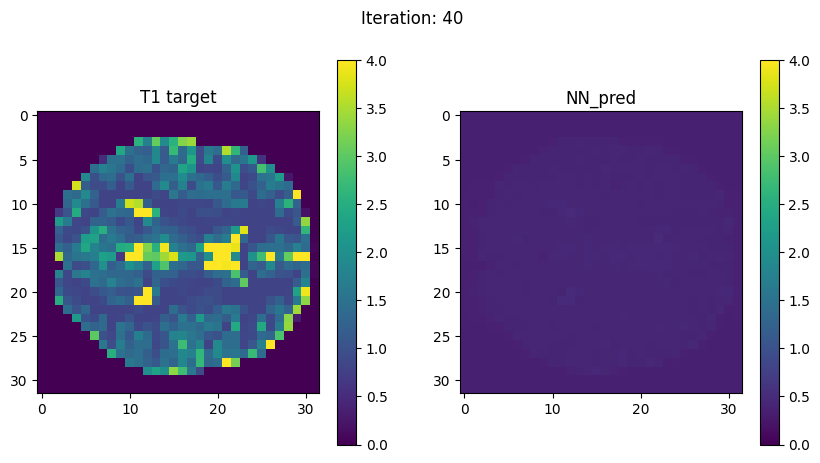

<IPython.core.display.Javascript object>

Calculating repetition 132 / 132 - done
[0.10000000149011612, 0.5, 1.0, 5.0]
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
[0.10000000149011612, 0.5, 1.0, 5.0]
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
Calculating repetition 132 / 132 - done
[0.10000000149011612, 0.5, 1.0, 5.0]
Calculating repetition 132 / 132 - done
Calculati

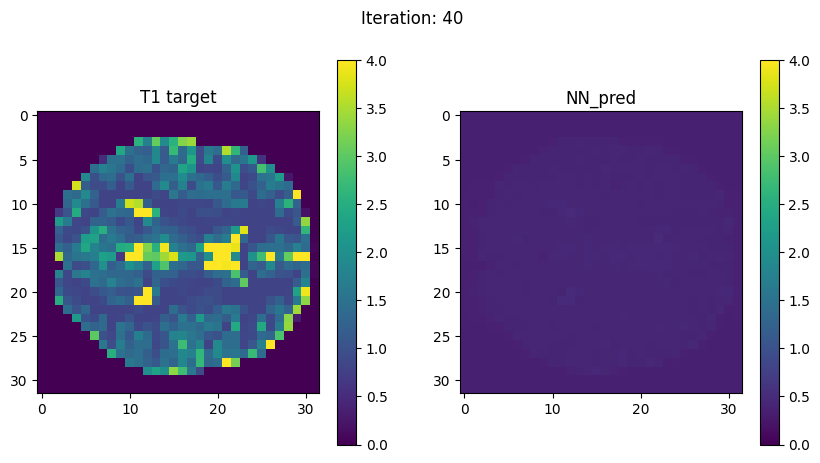

In [6]:
optimizable_params = [
    {'params': NN.parameters(), 'lr': 0.01}
]
lr = [0.01]

graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)

fig = plt.figure()
fig.suptitle("Iteration: 0")
axes1 = fig.add_subplot(121)
axes2 = fig.add_subplot(122)

hfig = display(fig, display_id=True)
draw()

progress_plot = ProgressPlot(x_label = "Iteration", line_names = ["Loss"], width = 800, height = 500)

from torch import autograd
optimizer = torch.optim.Adam(optimizable_params)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=500)
iteration = 0
for restart in range(50):  # Increase for better convergence
    optimizer.zero_grad()
    loss = calc_loss(iteration)
    loss.backward()
    optimizer.step()
    scheduler.step()
    iteration += 1